# 03 - Pedestrian couting


![](https://images.unsplash.com/45/ZLSw0SXxThSrkXRIiCdT_DSC_0345.jpg?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1053&q=80)

Photo by [David Marcu](https://unsplash.com/photos/JZXAr--Qdf4)

In [8]:
import sys
sys.path.append('../../../../../../models/research')
from object_detection.utils import label_map_util

PATH_TO_CKPT = '../../../../../../data/models/frozen_inference_graph.pb'
PATH_TO_LABELS = '../../../../../../models/research/object_detection/data/mscoco_label_map.pbtxt'
NUM_CLASSES = 90


In [3]:
import tensorflow as tf

# Compute the graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [11]:
from utils import run_inference_for_single_image
import numpy as np
import matplotlib.pyplot as plt

im1 = plt.imread('data/img1.jpg')
im2 = plt.imread('data/img2.jpg')
im3 = plt.imread('data/img3.jpg')
im4 = plt.imread('data/img4.jpg')
im5 = plt.imread('data/img5.jpg')

dict1 = run_inference_for_single_image(im1, detection_graph)
dict2 = run_inference_for_single_image(im2, detection_graph)
dict3 = run_inference_for_single_image(im3, detection_graph)
dict4 = run_inference_for_single_image(im4, detection_graph)
dict5 = run_inference_for_single_image(im5, detection_graph)

In [9]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [17]:
import numpy as np
def iou(box1, box2):
    xx1 = max(box1[1], box2[1])
    yy1 = max(box1[0], box2[0])
    xx2 = min(box1[3], box2[3])
    yy2 = min(box1[2], box2[2])
    
    intersect = (xx2-xx1)*(yy2-yy1)
    
    union = np.abs((box1[2]-box1[0])*(box1[3]-box1[1])) + np.abs((box2[2]-box2[0])*(box2[3]-box2[1])) - intersect
    return intersect/union

In [18]:
def apply_detection_threshold(detections, detection_threshold):
    picks = []
    
    for i in range(len(detections['detection_scores'])):
        if detections['detection_scores'][i] >= detection_threshold:
            picks.append(i)

    
    output = {'detection_scores': detections['detection_scores'][picks],
              'detection_boxes': detections['detection_boxes'][picks],
              'detection_classes': detections['detection_classes'][picks]}
    
    return output

In [19]:
def non_max_suppression(detections, iou_threshold, detection_threshold):
    
    detections = apply_detection_threshold(detections, detection_threshold)
    
    indices = np.arange(len(detections['detection_boxes']))
    
    
    output_scores = []
    output_boxes = []
    output_classes = []
    
    while len(indices)>0:
        # Get the highest score
        highest_score_idx = detections['detection_scores'].argmax()
        
        # Save the highest score
        output_scores.append(detections['detection_scores'][highest_score_idx])
        output_boxes.append(detections['detection_boxes'][highest_score_idx])
        output_classes.append(detections['detection_classes'][highest_score_idx])
        
        
        # Find out all overlapping boxes
        to_remove = []
        for i in range(len(detections['detection_boxes'])):
            # Check this is not the same box
            if i != highest_score_idx:
                # Check the IoU is above threshold
                if iou(detections['detection_boxes'][highest_score_idx],
                       detections['detection_boxes'][i]) > iou_threshold:
                    # To be removed from the dict
                    to_remove.append(i)

        # Remove them from the dict if any
        if len(to_remove)>0:
            detections['detection_scores'] = np.delete(detections['detection_scores'], to_remove)
            detections['detection_boxes'] = np.delete(detections['detection_boxes'], to_remove, axis=0)
            detections['detection_classes'] = np.delete(detections['detection_classes'], to_remove)
            indices = np.delete(indices, to_remove)


        detections['detection_scores'] = np.delete(detections['detection_scores'], highest_score_idx)
        detections['detection_boxes'] = np.delete(detections['detection_boxes'], highest_score_idx, axis=0)
        detections['detection_classes'] = np.delete(detections['detection_classes'], highest_score_idx)
        indices = np.delete(indices, highest_score_idx)

                            
    output = {'detection_scores': output_scores,
              'detection_boxes': np.array(output_boxes),
              'detection_classes': output_classes}

    return output

In [43]:
def keep_pedestrians_only(detections):
    
    output_scores = []
    output_boxes = []
    output_classes = []
    
    for i in range(len(detections['detection_classes'])):
        # Keep only pedestrians
        if detections['detection_classes'][i]==1 and detections['detection_scores'][i]>0:
            output_scores.append(detections['detection_scores'][i])
            output_boxes.append(detections['detection_boxes'][i])
            output_classes.append(detections['detection_classes'][i])

    output = {'detection_scores': output_scores,
              'detection_boxes': np.array(output_boxes),
              'detection_classes': output_classes}
    
    return output

In [48]:
# Apply non max suppression
iou_threshold = 0.5
detection_threshold = 0.7
non_max_dict1 = non_max_suppression(dict1, iou_threshold, detection_threshold)
non_max_dict2 = non_max_suppression(dict2, iou_threshold, detection_threshold)
non_max_dict3 = non_max_suppression(dict3, iou_threshold, detection_threshold)
non_max_dict4 = non_max_suppression(dict4, iou_threshold, detection_threshold)
non_max_dict5 = non_max_suppression(dict5, iou_threshold, detection_threshold)

In [49]:
# Keep only pedestrians
ped_dict1 = keep_pedestrians_only(non_max_dict1)
ped_dict2 = keep_pedestrians_only(non_max_dict2)
ped_dict3 = keep_pedestrians_only(non_max_dict3)
ped_dict4 = keep_pedestrians_only(non_max_dict4)
ped_dict5 = keep_pedestrians_only(non_max_dict5)

In [55]:
def display_image(im, dico):

    output_im = visualize_boxes_and_labels_on_image_array(im.copy(),
                                                          dico['detection_boxes'],
                                                          dico['detection_classes'],
                                                          dico['detection_scores'],
                                                          category_index,
                                                          #instance_masks=non_max_dict1.get('detection_masks'),
                                                          use_normalized_coordinates=True,
                                                          line_thickness=8)

    print('number of pedestrians detected:', len(dico['detection_classes']))
    plt.figure(figsize=(8,8))
    plt.imshow(output_im)
    plt.axis('off')

number of pedestrians detected: 2


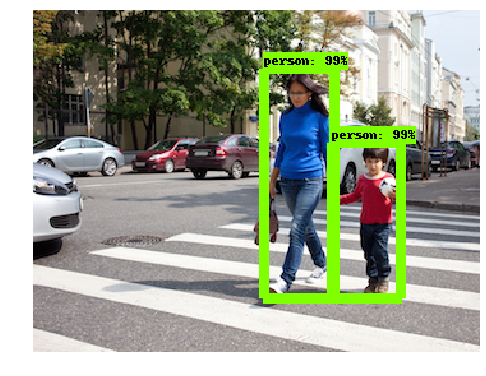

In [56]:
display_image(im1, ped_dict1)

number of pedestrians detected: 6


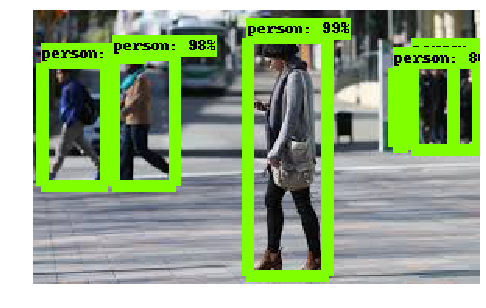

In [57]:
display_image(im2, ped_dict2)

number of pedestrians detected: 2


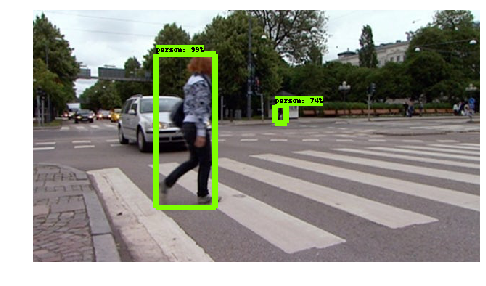

In [58]:
display_image(im3, ped_dict3)

number of pedestrians detected: 6


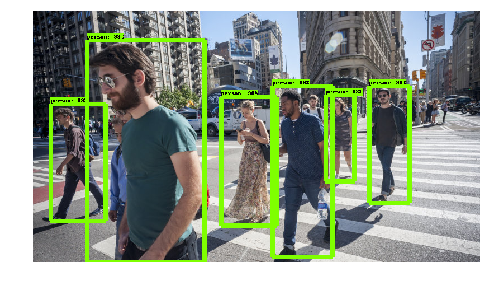

In [59]:
display_image(im4, ped_dict4)

number of pedestrians detected: 16


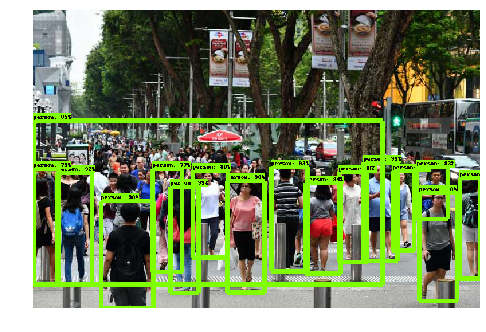

In [60]:
display_image(im5, ped_dict5)